In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.2048.demo"
snapshot_path = "/home/jheuristic/yozhik/agentnet_snapshots/"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


In [3]:
%load_ext autoreload
%autoreload 2

# This tutorial is a showcase on how to use AgentNet to learn arbitrary problems

* Playing 2048 from "http://2048game.com/"
* using PhantomJS and Selenium

__Phantomjs:__
```
For Linux (Debian):
sudo apt-get update
sudo apt-get install build-essential chrpath git-core libssl-dev libfontconfig1-dev libxft-dev
git clone git://github.com/ariya/phantomjs.git
cd phantomjs
git checkout 1.9
./build.sh

May work for Ubuntu 14.04:
sudo apt-get update
sudo apt-get install phantomjs


For Mac os:
git clone git://github.com/ariya/phantomjs.git
cd phantomjs
git checkout 1.9
./build.sh

```

__Selenium:__
```
pip install --upgrade pip
pip install selenium
```

* training in several threads at once
* using experience replay to train on game sessions
* keeping everything else as simple as possible

# Experiment setup
* Here we write a simple wrapper for 2048 web-game using selenium browser

In [5]:
from selenium import webdriver as wd
import time
import numpy as np

grid_size = [15,4,4]
class GameWrapper:
    def __init__(self):
        self.br = wd.PhantomJS(<path_to_where_phantomjs_is_built>) #insert your path here. For sudo-apt-get-installers, use wd.PhantomJS()
        self.br.get("http://2048game.com/")
        self.game = self.br.find_element_by_css_selector(".game-container")
        
        self.tile_container = self.br.find_element_by_css_selector(".tile-container")
        
    def get_score(self):
        score_text = self.br.find_element_by_css_selector(".score-container").text
        return int(score_text.split()[0])
        
    
    def send_keys(self,keys):
        assert not self.is_over()
        self.game.send_keys(keys)
        
    def get_state(self):
        grid = np.zeros(grid_size,dtype='bool')
        
        cells = self.tile_container.find_elements_by_class_name("tile")
        for cell in cells:
            attrs = cell.get_attribute("class").split()[1:]

            power = int(np.log2(int(attrs[0].split('-')[-1])))
            x,y = map(int,attrs[1].split('-')[-2:])

            grid[power,x-1,y-1] = True
        return grid
    
    def restart(self):
        self.br.find_element_by_css_selector(".restart-button").click()
            
    def is_over(self):
        try:
            self.br.find_element_by_class_name("game-over")
            return True
        except:
            return False
    def __del__(self):
        self.br.close()

In [6]:
#create several such wrappers, each containing a standalone phantomjs instance
gw = GameWrapper()

In [7]:
gw.send_keys('wasd')
print gw.get_score()
gw.br.close()
del gw

584


Exception selenium.common.exceptions.NoSuchWindowException: NoSuchWindowException() in <bound method GameWrapper.__del__ of <__main__.GameWrapper instance at 0x530cb48>> ignored


In [8]:
#Create an environment with all default parameters
import agentnet
env = agentnet.environment.session_pool.SessionPoolEnvironment(n_actions=1,n_observations=2,n_agent_memories=1)

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, we train two GRU layers [details below]
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy
  
  
### two-layer memory architecture
We train two memory states:
  * first one, based on observations,
  * second one, based on first one;

Note that here we update the second memory layer based on the CURRENT state
of the first one. Instead, you can try to feed it with a previous state.

The q-values are estimated on a concatenated state, effectively on both memory
states together, but there is no problem with limiting q-evaluator to only one:
just pass the correct gru layer as an incoming layer to the q-evaluator.

### Implementation:
We concatenate both memories into 1 state to pass it through the session loop.

To perform memory update, we need to slice the concatenated state back into
two memory states.

We do so by defining an input map function and passing it into agent.

We than concatenate two new states back to form a new memory state.



In [9]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Agent

In [10]:
import lasagne
n_hid_1=128 #first and only GRU memory
n_actions = 4


#grid observation
_grid_observation_layer = lasagne.layers.InputLayer([None,np.prod(grid_size)],name="obs_input")


#2x2 convolution
grid_as_img = lasagne.layers.reshape(_grid_observation_layer,(-1,)+tuple(grid_size))
cnn = lasagne.layers.Conv2DLayer(grid_as_img,num_filters=32,filter_size=(2,2),name='CNN')
cnn_ravel = lasagne.layers.ReshapeLayer(cnn,(-1,np.prod(cnn.output_shape[1:])))

#prev action as observation
_prev_action_observation_layer = lasagne.layers.InputLayer([None,n_actions],name="obs_prev_action")

#all observations together
joint_observation = lasagne.layers.concat([cnn_ravel, _prev_action_observation_layer])


#prev memory
_prev_gru1_layer = lasagne.layers.InputLayer([None,n_hid_1],name="prev_gru1_state_input")


#memory
gru1 = GRUMemoryLayer(n_hid_1,
                     joint_observation,
                     _prev_gru1_layer,
                     name="gru1")




#q_eval
q_eval = lasagne.layers.DenseLayer(gru1,
                                   num_units = n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,
                                   name="QEvaluator")
#resolver
epsilon = theano.shared(np.float32(0.5),"e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")



from collections import OrderedDict
#all together
agent = Agent([_grid_observation_layer,_prev_action_observation_layer],
              OrderedDict([
                    (gru1,_prev_gru1_layer),
              ]),
              q_eval,resolver)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[CNN.W,
 CNN.b,
 gru1.W_in_to_updategate,
 gru1.W_hid_to_updategate,
 gru1.b_updategate,
 gru1.W_in_to_resetgate,
 gru1.W_hid_to_resetgate,
 gru1.b_resetgate,
 gru1.W_in_to_hidden_update,
 gru1.W_hid_to_hidden_update,
 gru1.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


# creating sessions

In [12]:
applier_prev_action = T.scalar("prev_action",dtype='int32')
applier_grid_state = T.tensor3("grid_state",dtype=floatX)
applier_prev_gru1 = T.vector("prev_gru0",dtype=floatX)

action_one_hot = T.extra_ops.to_one_hot(applier_prev_action[None],n_actions,dtype='float32')

applier_observations = [applier_grid_state.ravel()[None,:],action_one_hot]


res =agent.get_agent_reaction({
        gru1:applier_prev_gru1[None,:],
 },applier_observations)


applier_actions,applier_new_states,applier_policy = res

applier_fun = theano.function([
        applier_grid_state,applier_prev_action,
        applier_prev_gru1,
        ],
        applier_actions+applier_new_states+applier_observations)

In [13]:


def get_action(gw,prev_action=0,prev_gru1=None):
    
    state = gw.get_state()
    
    if prev_gru1 is None:
        prev_gru1 = np.zeros(n_hid_1,floatX)
    
    
    
    action,new_gru1,obs_grid,obs_prev_action = applier_fun(state,prev_action,prev_gru1,)
    return action[0],new_gru1[0],(obs_grid[0],obs_prev_action[0])
    
    

In [14]:
def interact(gw,n_steps=20):
    
    
    rewards = []
    actions = []
    observation_tuples = []
    memories = []
    
    prev_action = 0
    prev_gru1 = None
    prev_score = gw.get_score()
    
    for i in range(n_steps):
        
        

        prev_action,prev_gru1,obs_tpl = get_action(gw,prev_action,prev_gru1)
        
        gw.send_keys('wasd'[prev_action])
        
        actions.append(prev_action)
        observation_tuples.append(obs_tpl)
        memories.append([prev_gru1])
        
        
        new_score = gw.get_score()
        dscore = new_score - prev_score
        rewards.append(np.log(dscore+1))
        prev_score = new_score
        
        
        if gw.is_over():
            print "Last session got",prev_score,"points"
            break
    
    return zip(*observation_tuples),actions,rewards,zip(*memories)
        
        
    
    
    
    

In [15]:
def rebuild_pool(gw,sim_length = 50,seq_length=5,n_subseqs = 10):

    while True:

        if gw.is_over():
            gw.restart()
        observations,actions,rewards,memories = interact(gw,sim_length)
        print "Got", len(actions),"turns"
        print "So far",gw.get_score(),"points"
        if len(actions) > seq_length+3:
            break
        else:
            print "discarded, replaying"
            

    observation_seqs=  [ [], []] 
    action_seqs = []
    reward_seqs = []
    prev_memories = []

    for subseq_start in np.random.randint(1, len(actions) - seq_length -1, size=n_subseqs):
        observation_seqs[0].append(observations[0][subseq_start:subseq_start+seq_length])
        observation_seqs[1].append(observations[1][subseq_start:subseq_start+seq_length])
        action_seqs.append(actions[subseq_start:subseq_start+seq_length])
        reward_seqs.append(rewards[subseq_start:subseq_start+seq_length])
        
        prev_memories.append(memories[0][subseq_start-1])


    env.load_sessions(observation_seqs,[action_seqs],reward_seqs,prev_memories=[prev_memories])



In [16]:
gw = GameWrapper()
rebuild_pool(gw)


Got 50 turns
So far 972 points


In [17]:
#produce interaction sequences of length <= 10
state_seq,observation_seqs,agent_state,action_seq,qvalues_seq = agent.get_sessions(
    env,
    session_length=5,
    batch_size=env.batch_size,
)


observation_grid,observation_prev_action = observation_seqs

gru1_seq = agent_state[gru1]

#get rewards for all actions
rewards_seq = env.rewards

#get indicator whether session is still active
is_alive_seq = T.ones_like(rewards_seq,dtype='int8')


# Evaluating loss function
* This part is similar to the basic tutorial but for the fact that we use 3-step q-learning
 
 
 #### Get (prediction,reference) pairs

In [18]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning_n_step

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')


reference_Qvalues = qlearning_n_step.get_reference_Qvalues(qvalues_seq,
                               action_seq,
                               rewards_seq,
                               n_steps=3,
                               gamma_or_gammas=gamma,)

In [19]:
#zero-out future rewards at session end
from agentnet.utils.mdp import get_end_indicator

end_action_ids = get_end_indicator(is_alive_seq).nonzero()

# "set reference Qvalues at end action ids to just the immediate rewards"
reference_Qvalues = T.set_subtensor(reference_Qvalues[end_action_ids],
                                    rewards_seq[end_action_ids])

In [20]:
#prevent gradient updates over reference Qvalues (since they depend on predicted Qvalues)
from agentnet.utils import consider_constant
reference_Qvalues = consider_constant(reference_Qvalues)

In [21]:
from agentnet.utils.mdp import get_action_Qvalues
action_Qvalues = get_action_Qvalues(qvalues_seq,action_seq)

#### Define loss functions

In [22]:
#tensor of elementwise squared errors
squared_error = lasagne.objectives.squared_error(reference_Qvalues,action_Qvalues)

#zero-out ticks after session ended
squared_error = squared_error * is_alive_seq

#compute average of squared error sums per session
mse_loss = squared_error.sum() / is_alive_seq.sum()

In [23]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4

In [24]:
loss = mse_loss + reg_l2

#### Compute weight updates

In [25]:

updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.01)

#### Some auxilary evaluation metrics

In [26]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [27]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [28]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        gru1_seq,qvalues_seq, action_seq,rewards_seq,reference_Qvalues,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, reference_qv_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   #hidden_seq=hidden_log, #do not plot hidden since there's too many actions already
                   reference_policy_seq = reference_qv_log,
                   action_names=["w","a","s","d"],
                   legend = False, #do not show legend since there's too many labeled objects
                  plot_policy = with_plots)

In [30]:
from agentnet.utils.persistence import load
load(resolver,"../../../agentnet_snapshots/tutorial.2048.demo.epoch2000.pcl")

session # 0
 w(qv = 2.47560715675) -> 0.0(ref = 3.04537463188) |  w(qv = 3.20565748215) -> 0.0(ref = 3.10070347786) |  a(qv = 1.44869124889) -> 2.56494927406(ref = 3.26389837265) |  s(qv = 0.963798046112) -> 0.0(ref = 0.735735952854) |  s(qv = 0.774458885193) -> 4.23410654068(ref = 4.23410654068) | reached max session length


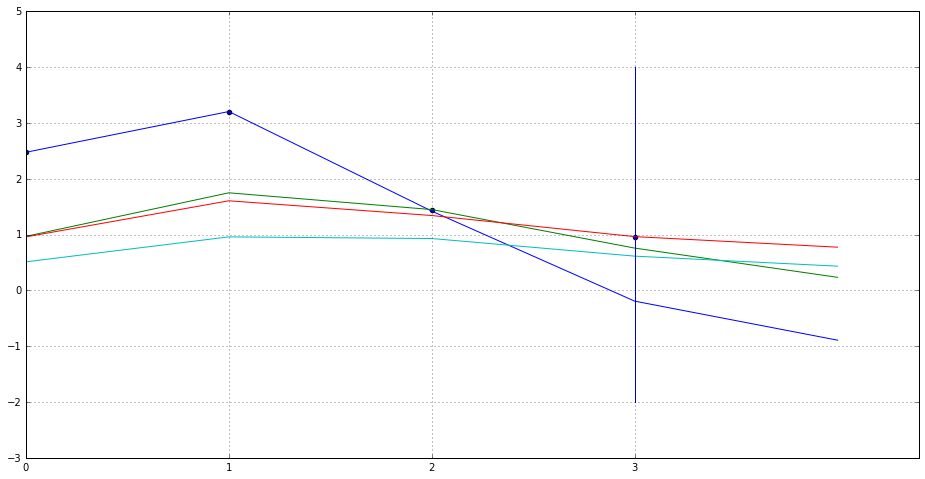

session # 1
 w(qv = 2.47560715675) -> 0.0(ref = 2.79477477074) |  w(qv = 2.94186830521) -> 0.0(ref = 0.714501976967) |  a(qv = 1.56826722622) -> 0.0(ref = 0.752107381821) |  w(qv = 0.191259369254) -> 0.0(ref = 0.791692018509) |  a(qv = 0.833360016346) -> 0.0(ref = 0.0) | reached max session length


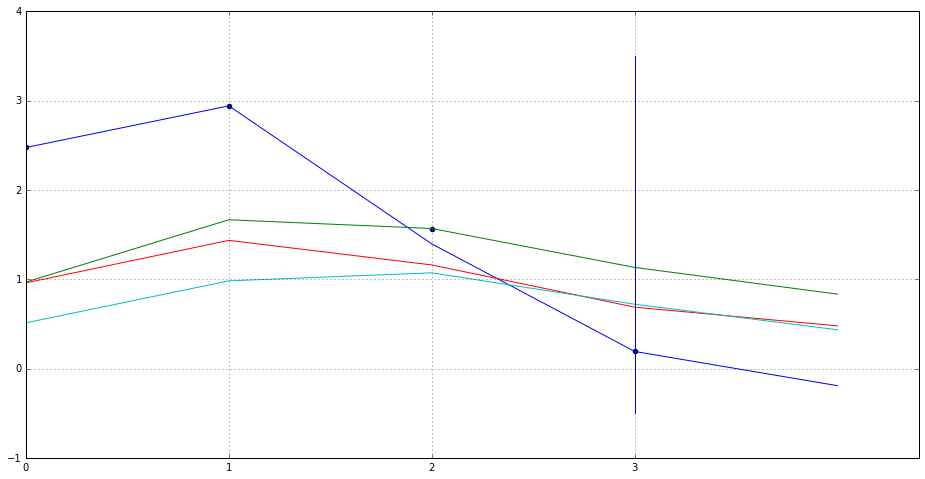

session # 2
 w(qv = 2.47560715675) -> 0.0(ref = 2.79477477074) |  w(qv = 2.94186830521) -> 0.0(ref = 0.86280465126) |  a(qv = 1.56826722622) -> 0.0(ref = 0.908215463161) |  a(qv = 1.13242304325) -> 0.0(ref = 0.956016302109) |  a(qv = 1.00633299351) -> 4.85981225967(ref = 4.85981225967) | reached max session length


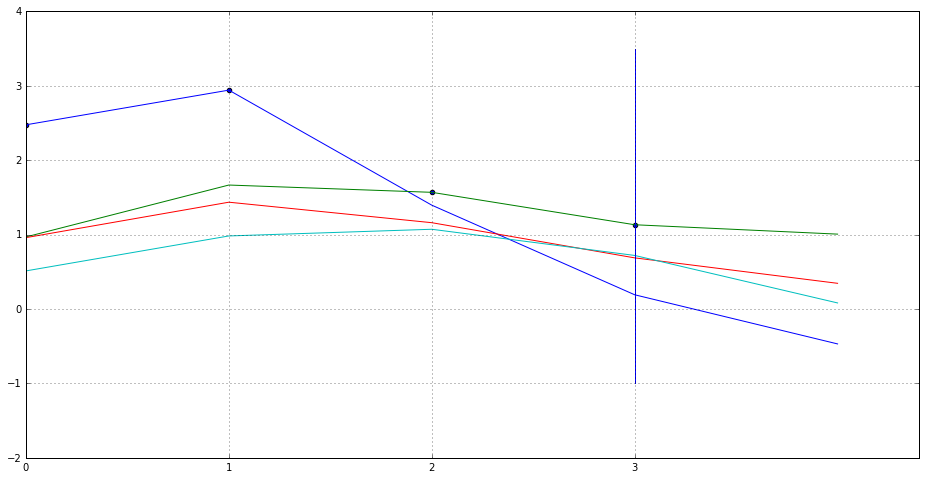

session # 3
 w(qv = 2.47560715675) -> 0.0(ref = 2.67982745171) |  w(qv = 2.82087111473) -> 0.0(ref = 0.673648118973) |  a(qv = 1.52959191799) -> 0.0(ref = 0.709103286266) |  a(qv = 1.06954741478) -> 0.0(ref = 0.746424496174) |  a(qv = 0.785710036755) -> 0.0(ref = 0.0) | reached max session length


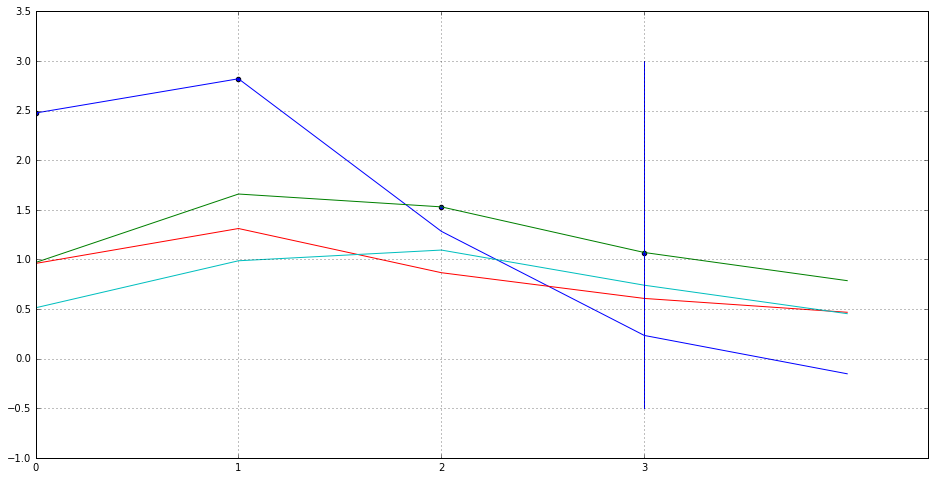

session # 4
 w(qv = 2.47560715675) -> 0.0(ref = 2.66735482216) |  w(qv = 2.80774188042) -> 0.0(ref = 2.16335463524) |  a(qv = 1.47782063484) -> 1.6094379425(ref = 2.2772154808) |  a(qv = 1.06286156178) -> 0.0(ref = 0.702923595905) |  a(qv = 0.739919602871) -> 0.0(ref = 0.0) | reached max session length


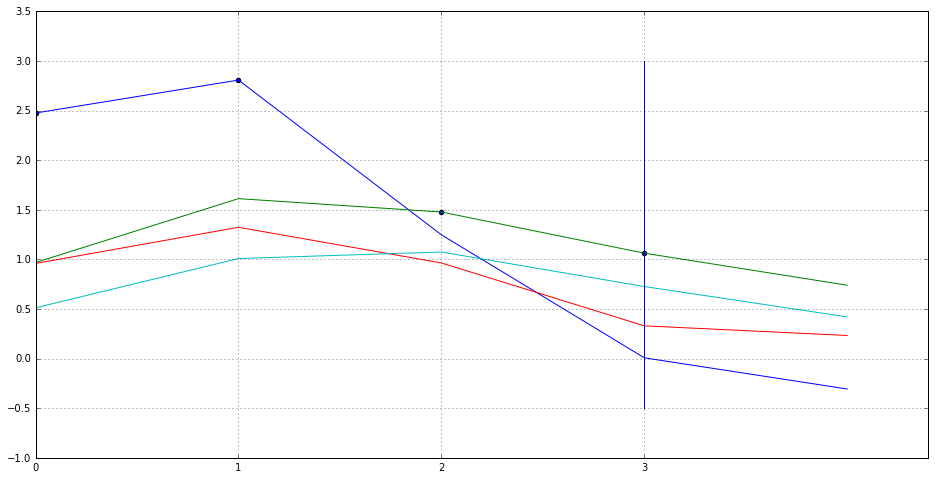

session # 5
 w(qv = 2.47560715675) -> 0.0(ref = 2.79477477074) |  w(qv = 2.94186830521) -> 0.0(ref = 0.714501976967) |  a(qv = 1.56826722622) -> 0.0(ref = 0.752107381821) |  a(qv = 1.13242304325) -> 0.0(ref = 0.791692018509) |  a(qv = 0.833360016346) -> 0.0(ref = 0.0) | reached max session length


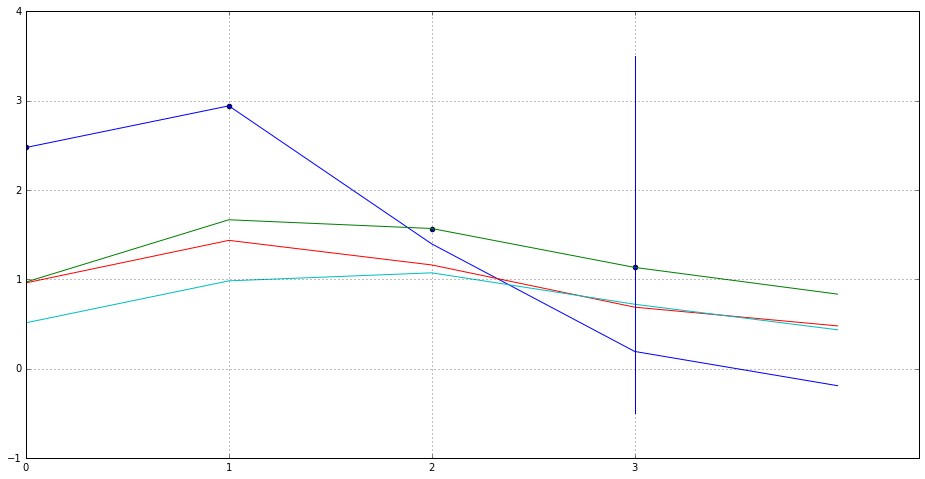

session # 6
 w(qv = 2.47560715675) -> 2.83321332932(ref = 5.87014818192) |  w(qv = 3.19677352905) -> 1.6094379425(ref = 5.47290325165) |  a(qv = 1.43485319614) -> 3.49650764465(ref = 4.0668053627) |  s(qv = 0.828337490559) -> 0.0(ref = 0.600313603878) |  s(qv = 0.631909072399) -> 0.0(ref = 0.0) | reached max session length


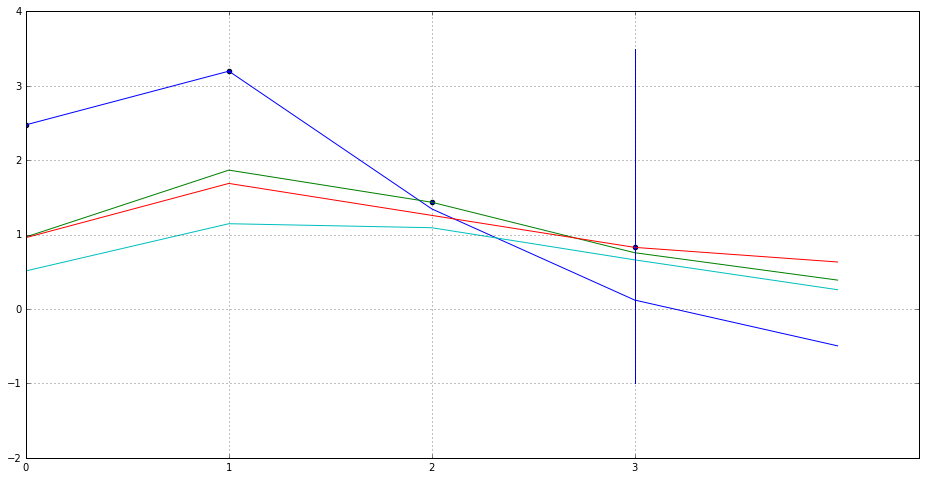

session # 7
 w(qv = 2.47560715675) -> 3.49650764465(ref = 6.54188251495) |  w(qv = 3.20565748215) -> 0.0(ref = 0.604538500309) |  a(qv = 1.44869124889) -> 0.0(ref = 0.63635635376) |  s(qv = 0.922814965248) -> 0.0(ref = 0.669848799706) |  s(qv = 0.705103993416) -> 2.56494927406(ref = 2.56494927406) | reached max session length


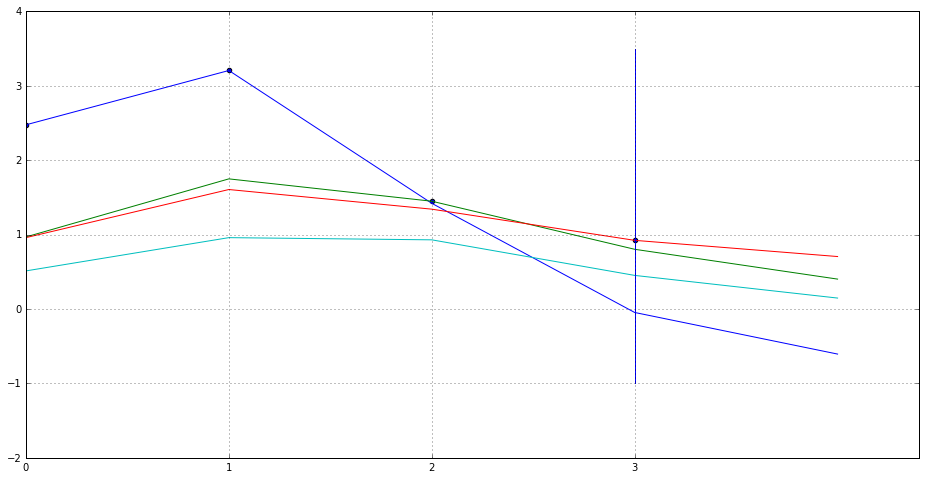

session # 8
 w(qv = 2.47560715675) -> 0.0(ref = 2.79477500916) |  w(qv = 2.94186854362) -> 0.0(ref = 0.86280477047) |  a(qv = 1.56826770306) -> 0.0(ref = 0.908215582371) |  a(qv = 1.13242328167) -> 0.0(ref = 0.956016421318) |  a(qv = 1.00633311272) -> 4.85981225967(ref = 4.85981225967) | reached max session length


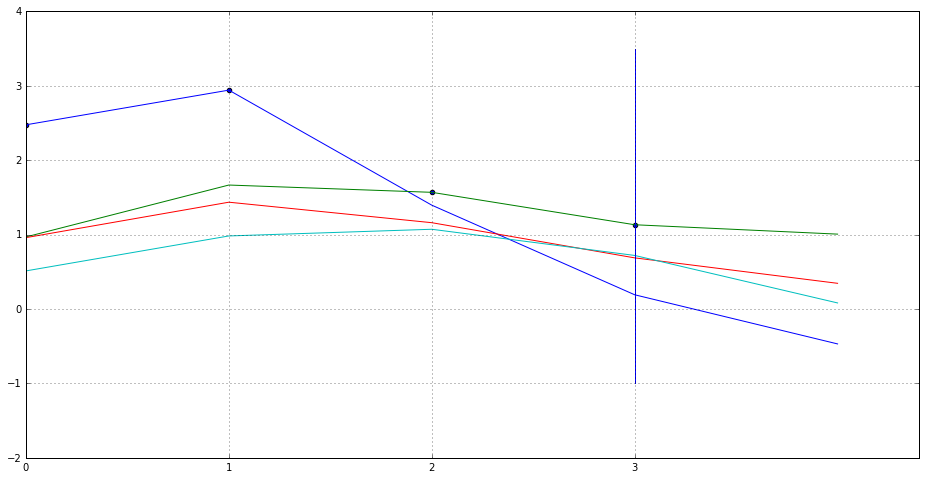

session # 9
 w(qv = 2.47560715675) -> 1.6094379425(ref = 4.42384243011) |  w(qv = 2.96253108978) -> 3.49650764465(ref = 4.08216810226) |  w(qv = 1.51315975189) -> 0.0(ref = 0.61648452282) |  d(qv = 0.493266314268) -> 0.0(ref = 0.648931086063) |  s(qv = 0.683085381985) -> 0.0(ref = 0.0) | reached max session length


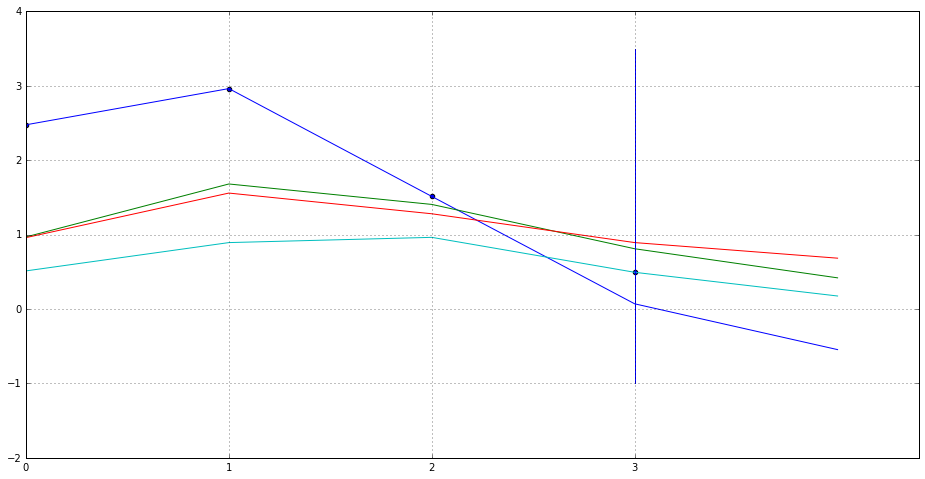

In [32]:
#visualize untrained network performance (which is mostly random)
epsilon.set_value(0.05)
display_sessions(with_plots=True)

# Training loop

In [33]:
#tools for model persistence (in progress now. Requires unique names)
from agentnet.utils.persistence import save,load
import os

In [34]:
from agentnet.display import Metrics
score_log = Metrics()

In [35]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

In [36]:
gw = GameWrapper()

In [37]:
rebuild_pool(gw,sim_length=500)

Last session got 2588 points
Got 402 turns
So far 2588 points


In [ ]:
n_epochs = 100000
batch_size= 10

for i in range(n_epochs):    
    
    
    #train
    while True:
        try:
            rebuild_pool(gw)
            break
        except:
            pass
        try:
            gw.br.close()
        except:pass
        gw = GameWrapper()
            
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%1 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

    if epoch_counter %100 ==0:
        print "Learning curves:"
        score_log.plot()


        print "Random session examples"
        display_sessions(with_plots=False)
    
    #save snapshot
    if epoch_counter %1000 ==0:
        snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), epoch_counter)
        save(resolver,snap_name)
        print "saved", snap_name

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

Got 50 turns
So far 572 points
epoch 1,loss 11.32123, epsilon 0.49910, rewards: ( e-greedy 0.73384, greedy 0.73384) 
rec 11.157 reg 0.164
Last session got 804 points
Got 41 turns
So far 804 points
epoch 2,loss 11.77342, epsilon 0.49820, rewards: ( e-greedy 1.16181, greedy 1.16181) 
rec 11.609 reg 0.164
Got 50 turns
So far 312 points
epoch 3,loss 7.14857, epsilon 0.49731, rewards: ( e-greedy 1.71862, greedy 1.71862) 
rec 6.985 reg 0.164
Got 50 turns
So far 556 points
epoch 4,loss 6.73784, epsilon 0.49641, rewards: ( e-greedy 2.11097, greedy 2.11097) 
rec 6.574 reg 0.164
Last session got 724 points
Got 38 turns
So far 724 points
epoch 5,loss 6.33665, epsilon 0.49552, rewards: ( e-greedy 2.41067, greedy 2.41067) 
rec 6.173 reg 0.164
Got 50 turns
So far 220 points
epoch 6,loss 5.39298, epsilon 0.49463, rewards: ( e-greedy 2.61412, greedy 2.61412) 
rec 5.229 reg 0.164
Last session got 416 points
Got 33 turns
So far 416 points
epoch 7,loss 10.89411, epsilon 0.49374, rewards: ( e-greedy 3.159

Exception selenium.common.exceptions.WebDriverException: WebDriverException() in <bound method GameWrapper.__del__ of <__main__.GameWrapper instance at 0x19268710>> ignored


Got 50 turns
So far 236 points
epoch 31,loss 5.19915, epsilon 0.47295, rewards: ( e-greedy 5.48733, greedy 5.48733) 
rec 5.035 reg 0.164


In [ ]:
current_epsilon

# Evaluating results

In [ ]:
score_log.plot("final")

In [ ]:
print "Random session examples"
rebuild_pool(gw)
display_sessions(with_plots=True)


In [ ]:
#load earlier snapshot.
#warning - this overrides the latest network params with earlier ones. 
#Replace 20000 with some 100000 if you wish to load latest snapshod back.
snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), 20000)
load(resolver,snap_name)

In [ ]:
print "Random session examples"
rebuild_pool(gw)
display_sessions(with_plots=True)
